## Twitter Sentimental Analysis

## Packages Import

In [31]:
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
import joblib as jb
from time import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings("ignore")

## Read the train data

In [32]:
column_names=['id','company','feelings','tweet']
twitter_sentimental_analysis=pd.read_csv("twitter_training.csv",sep=',',names=column_names)

In [33]:
# To display the top 5 rows
twitter_sentimental_analysis.head(5)

,id,company,feelings,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Data Pre-Processing

In [34]:
## Copy the dataset
t_data= twitter_sentimental_analysis.copy()

## In this step come to know shape of the data

In [35]:
t_data.shape

(74682, 4)

## Identifying unique values in data

In [36]:
t_data.nunique()

id          12447
company        32
feelings        4
tweet       69491
dtype: int64

## To get all columns name

In [37]:
t_data.columns

Index(['id', 'company', 'feelings', 'tweet'], dtype='object')

## Information about the dataset

In [38]:
t_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        74682 non-null  int64 
 1   company   74682 non-null  object
 2   feelings  74682 non-null  object
 3   tweet     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


## Checking for null values

In [39]:
t_data.isnull().sum().sort_values(ascending=False)[:10]

tweet       686
id            0
company       0
feelings      0
dtype: int64

## Droping the null values

In [40]:
## If no id of tweet is null, just replace it with 0

t_data.dropna(inplace=True)

In [41]:
t_data.isnull().sum().sort_values(ascending=False)[:10]

id          0
company     0
feelings    0
tweet       0
dtype: int64

## Checking for duplicate rows

In [42]:
## we got total number of rows,columns
t_data.shape

(73996, 4)

In [43]:
## that we have more duplicates we have no option so we drop the datas
duplicate_rows_df = t_data[t_data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (2340, 4)


## Droping the duplicate rows

In [44]:
## drop the duplicated values
t_data = t_data.drop_duplicates()
t_data.head(5)

,id,company,feelings,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Exploratory Data Analysis

<Axes: xlabel='feelings', ylabel='count'>

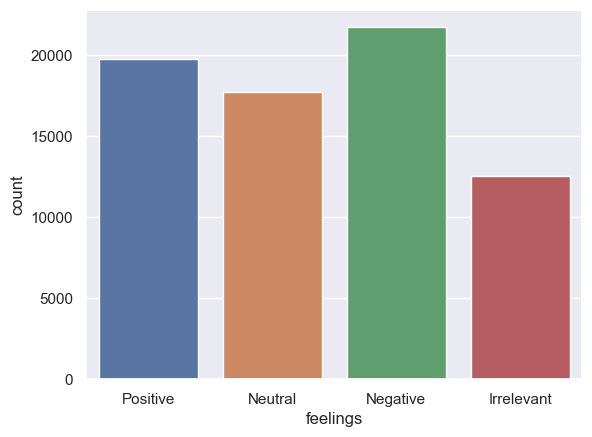

In [45]:
sns.countplot(x='feelings',data=t_data)

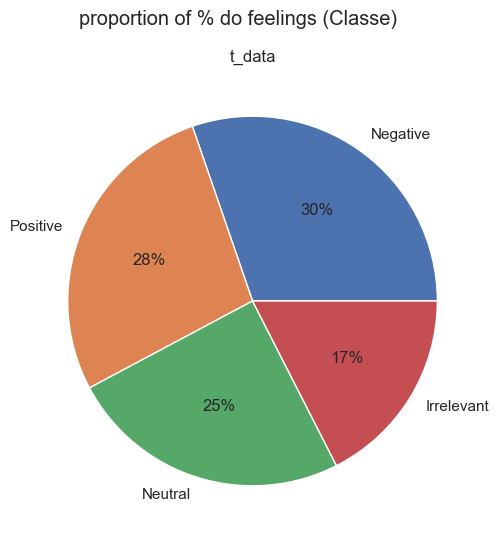

In [46]:
fig, ax = plt.subplots(1,figsize=(12,6))

ax.pie(t_data['feelings'].value_counts(),labels=t_data['feelings'].value_counts().index,autopct='%.f%%')

fig.suptitle("proportion of % do feelings (Classe)")
ax.set_title("t_data")

plt.show()

In [47]:
# Count the number of times it is related to a company or game
t_data['company'].value_counts()

company
TomClancysRainbowSix                 2328
Verizon                              2319
MaddenNFL                            2315
CallOfDuty                           2314
Microsoft                            2304
WorldOfCraft                         2300
NBA2K                                2299
LeagueOfLegends                      2296
TomClancysGhostRecon                 2291
Facebook                             2289
ApexLegends                          2278
johnson&johnson                      2257
Battlefield                          2255
Amazon                               2249
CallOfDutyBlackopsColdWar            2242
FIFA                                 2238
Dota2                                2225
Overwatch                            2220
Hearthstone                          2219
HomeDepot                            2216
GrandTheftAuto(GTA)                  2208
Borderlands                          2206
Xbox(Xseries)                        2201
Google                    

In [48]:
# Sentiment count by company or game
tsa_data=t_data.groupby(by=["company","feelings"]).count().reset_index()
tsa_data.head(10)

,company,feelings,id,tweet
0,Amazon,Irrelevant,185,185
1,Amazon,Negative,565,565
2,Amazon,Neutral,1197,1197
3,Amazon,Positive,302,302
4,ApexLegends,Irrelevant,185,185
5,ApexLegends,Negative,574,574
6,ApexLegends,Neutral,913,913
7,ApexLegends,Positive,606,606
8,AssassinsCreed,Irrelevant,256,256
9,AssassinsCreed,Negative,365,365


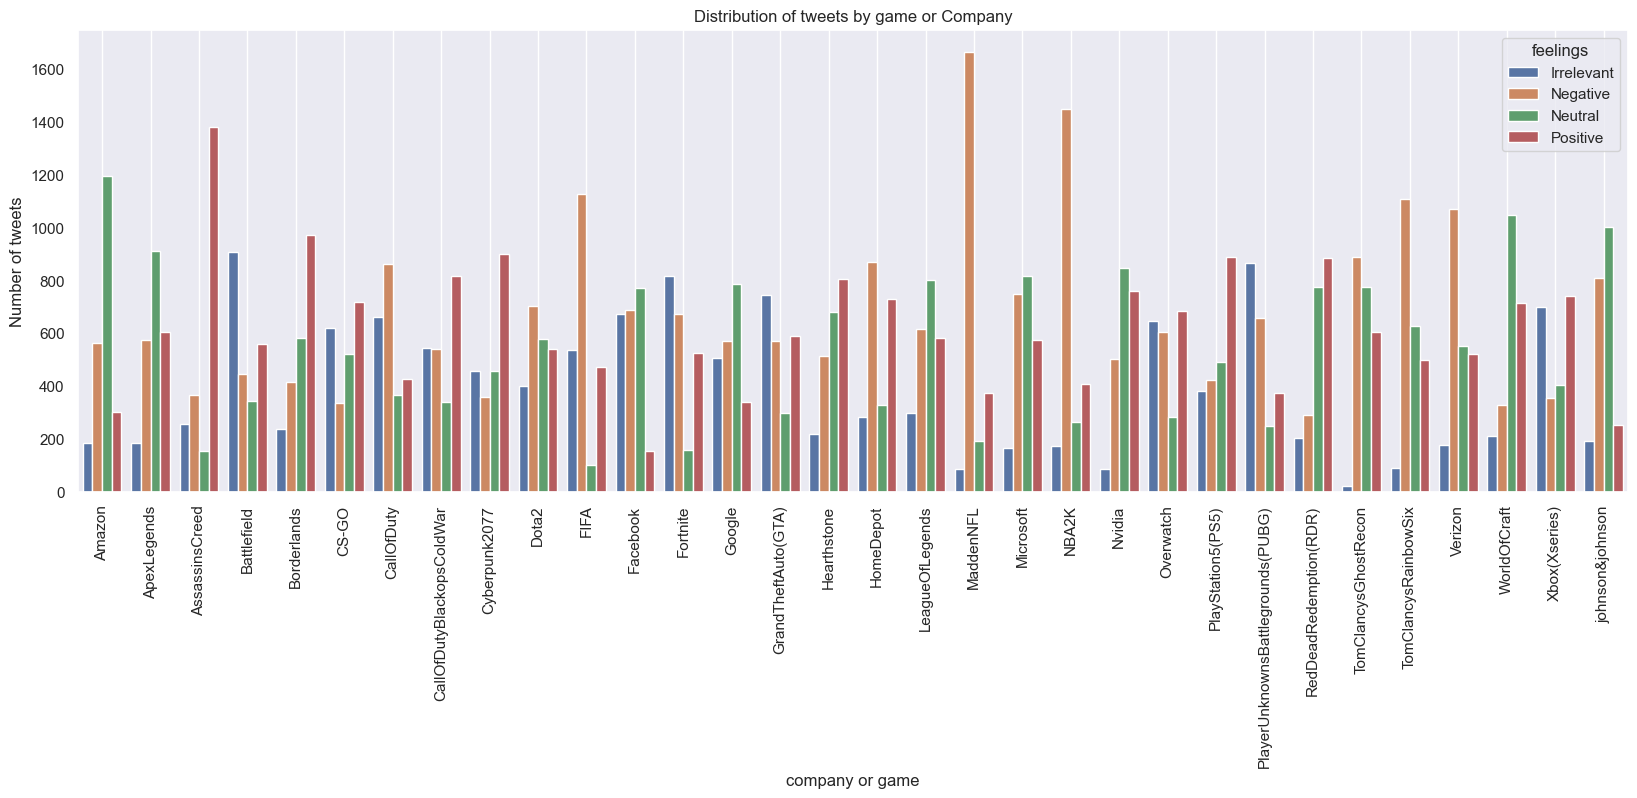

In [49]:
plt.figure(figsize=(20,6))
sns.barplot(data=tsa_data,x="company",y="id",hue='feelings')
plt.xticks(rotation=90)
plt.xlabel("company or game")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets by game or Company")
plt.show()

## Word chart of each Sentiment

					feelings Positive


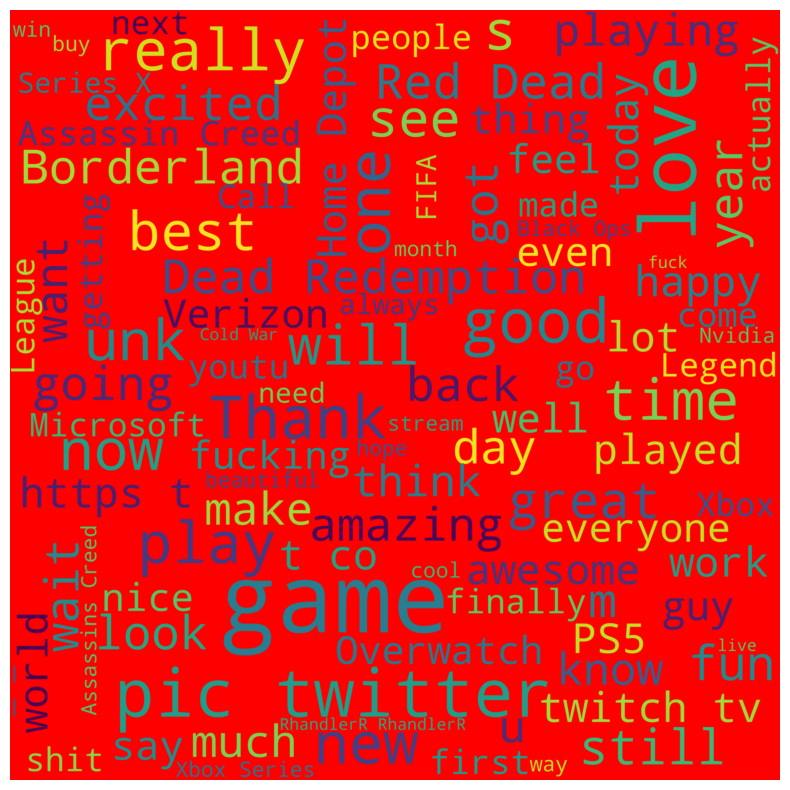

In [50]:
print("\t\t\t\t\tfeelings Positive")

word_cloud_text = ''.join(t_data[t_data["feelings"]=="Positive"].tweet)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="red",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
			

					feelings Negative


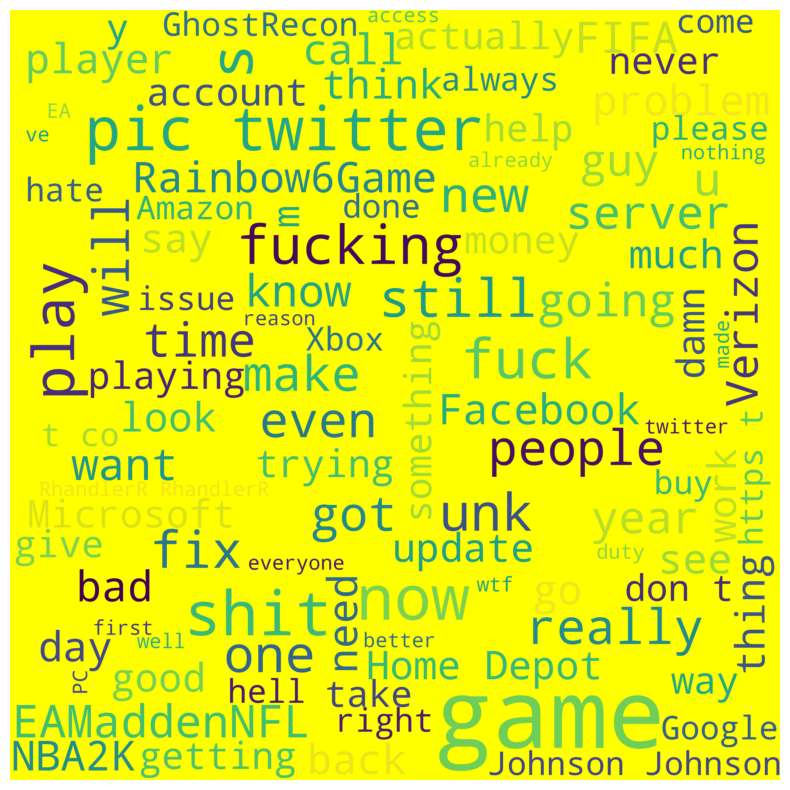

In [51]:
print("\t\t\t\t\tfeelings Negative")

word_cloud_text = ''.join(t_data[t_data["feelings"]=="Negative"].tweet)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="yellow",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

					feelings Neutral


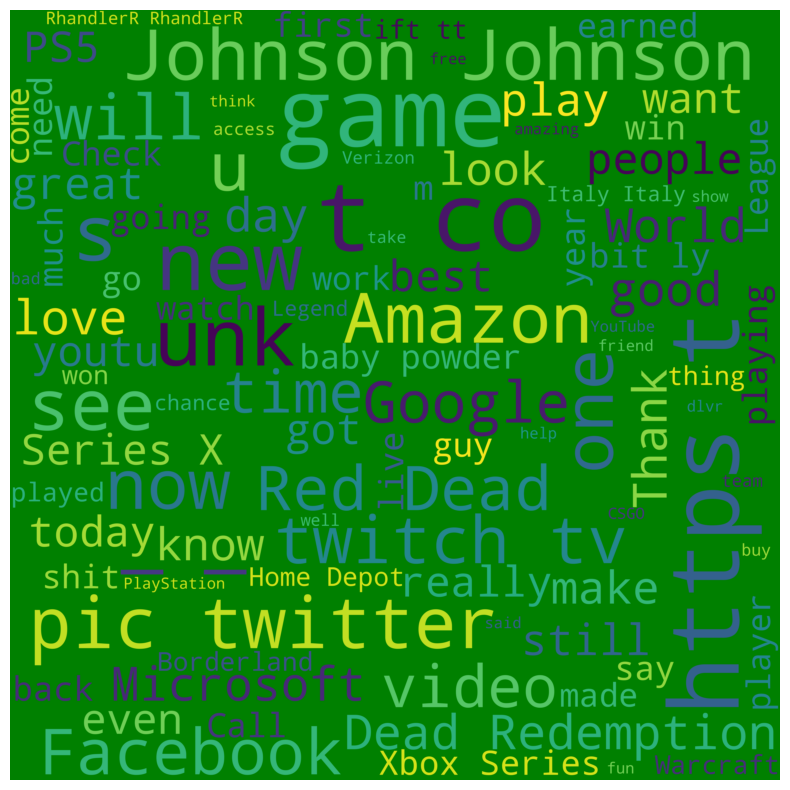

In [52]:
print("\t\t\t\t\tfeelings Neutral")

word_cloud_text = ''.join(t_data[t_data["feelings"]=="Neutral"].tweet)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="green",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

					feelings Irrelevant


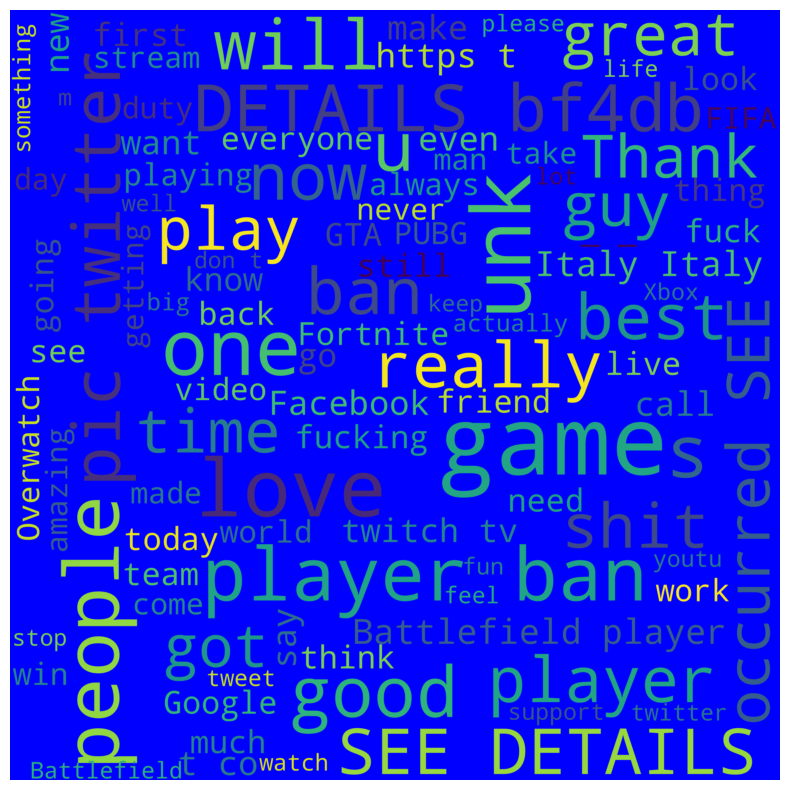

In [53]:
print("\t\t\t\t\tfeelings Irrelevant")

word_cloud_text = ''.join(t_data[t_data["feelings"]=="Irrelevant"].tweet)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="blue",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Classification Model

In [54]:
# Split the dataset into training and testing data
X = t_data['tweet']
y = t_data['feelings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Vectorization of text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the Naive Bayes model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Evaluate the model
accuracy = model.score(X_test_vec, y_test)
print(f'model accuracy: {accuracy * 100:.2f}%')

model accuracy: 75.07%


In [60]:
# Example text for sorting
new_text = ["I grow and improve every day",
              "mani is so bad man",
              "Some days are harder than others,I’m doing my best today,Today I’m OK",
              "Dad, take a picture"]
# New text vectorization
new_text_vec = vectorizer.transform(new_text)

# Perform sentiment prediction
predicted_feeling = model.predict(new_text_vec)

# Print the predicted sentiments
print("predicted feeling:", predicted_feeling)

predicted feeling: ['Neutral' 'Negative' 'Positive' 'Irrelevant']


In [61]:
y_pred=model.predict(X_test_vec)
y_true=y_test

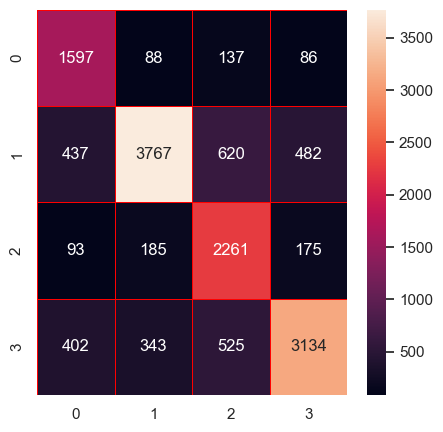

In [62]:
cm=confusion_matrix(y_pred,y_true)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.show()

In [63]:
jb.dump(model,'/')

FileNotFoundError: [Errno 2] No such file or directory: 'twitter_data/train/model/model.pkl'